In [1]:
from utilities import init_bigquery_client
from google.cloud import bigquery
import os
import pandas as pd
import numpy as np
import plotly.express as px

#init BigQuery client
bq = init_bigquery_client()

Using BigQuery credentials: etl-testing-478716-c0b6c2c512e0.json


## Perform bulk queries

In [13]:
# Read from the 'users' table in BigQuery
query = """
    SELECT *
    FROM `etl-testing-478716.firebase_etl_prod.users`
"""
users_df = bq.query(query).to_dataframe()

query = """
    SELECT *
    FROM `etl-testing-478716.firebase_etl_prod.events`
"""
events_df = bq.query(query).to_dataframe()
#filtering out duplicate events to get most recent edit
events_df = events_df.sort_values('createdAt', ascending=False).drop_duplicates(subset=['document_id'], keep='first')

/opt/miniconda3/envs/heyyall/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.


In [ ]:
from plotnine import *

In [37]:
events_df.columns

Index(['document_id', 'title', 'description', 'creator_name', 'user_id',
       'createdAt', 'eventDate', 'type', 'location_name', 'coverPhoto',
       'location_latitude', 'location_longitude', 'startTime', 'endTime',
       'shortId', 'etl_loaded_at'],
      dtype='object')

In [38]:
#Correlation between weekly user signup and weekly event creations
weekly_events_df = events_df[events_df['type'] != 'checkin'].resample('W', on='createdAt').size().reset_index(name='event_creations')
weekly_eventdate_df = events_df[events_df['type'] != 'checkin'].resample('W', on='eventDate').size().reset_index(name='event_dates')
weekly_users_df = users_df[users_df['createdAt'].notnull()].resample('W', on='createdAt').size().reset_index(name='user_signups')

In [39]:
weekly_eventdate_df.head()

,eventDate,event_dates
0,2025-11-16 00:00:00+00:00,11
1,2025-11-23 00:00:00+00:00,19
2,2025-11-30 00:00:00+00:00,9
3,2025-12-07 00:00:00+00:00,9
4,2025-12-14 00:00:00+00:00,4


In [41]:
weekly_users_df.head()

,createdAt,user_signups
0,2025-11-16 00:00:00+00:00,5
1,2025-11-23 00:00:00+00:00,8
2,2025-11-30 00:00:00+00:00,42
3,2025-12-07 00:00:00+00:00,47
4,2025-12-14 00:00:00+00:00,15


In [42]:
from scipy.stats import pearsonr

#pearson correlation between weekly user signups and weekly event creations
merged_df = pd.merge(weekly_users_df, weekly_events_df, left_on='createdAt', right_on='createdAt', how='inner')
correlation, p_value = pearsonr(merged_df['user_signups'], merged_df['event_creations'])
print(f'Pearson correlation: {correlation}, P-value: {p_value}')

merged_df2 = pd.merge(weekly_users_df, weekly_eventdate_df, left_on='createdAt', right_on='eventDate', how='inner')

Pearson correlation: 0.14347610571621114, P-value: 0.656427687700821


In [44]:

correlation, p_value = pearsonr(merged_df2['user_signups'], merged_df2['event_dates'])
print(f'Pearson correlation: {correlation}, P-value: {p_value}')

Pearson correlation: 0.18204418407612558, P-value: 0.5712151207833451


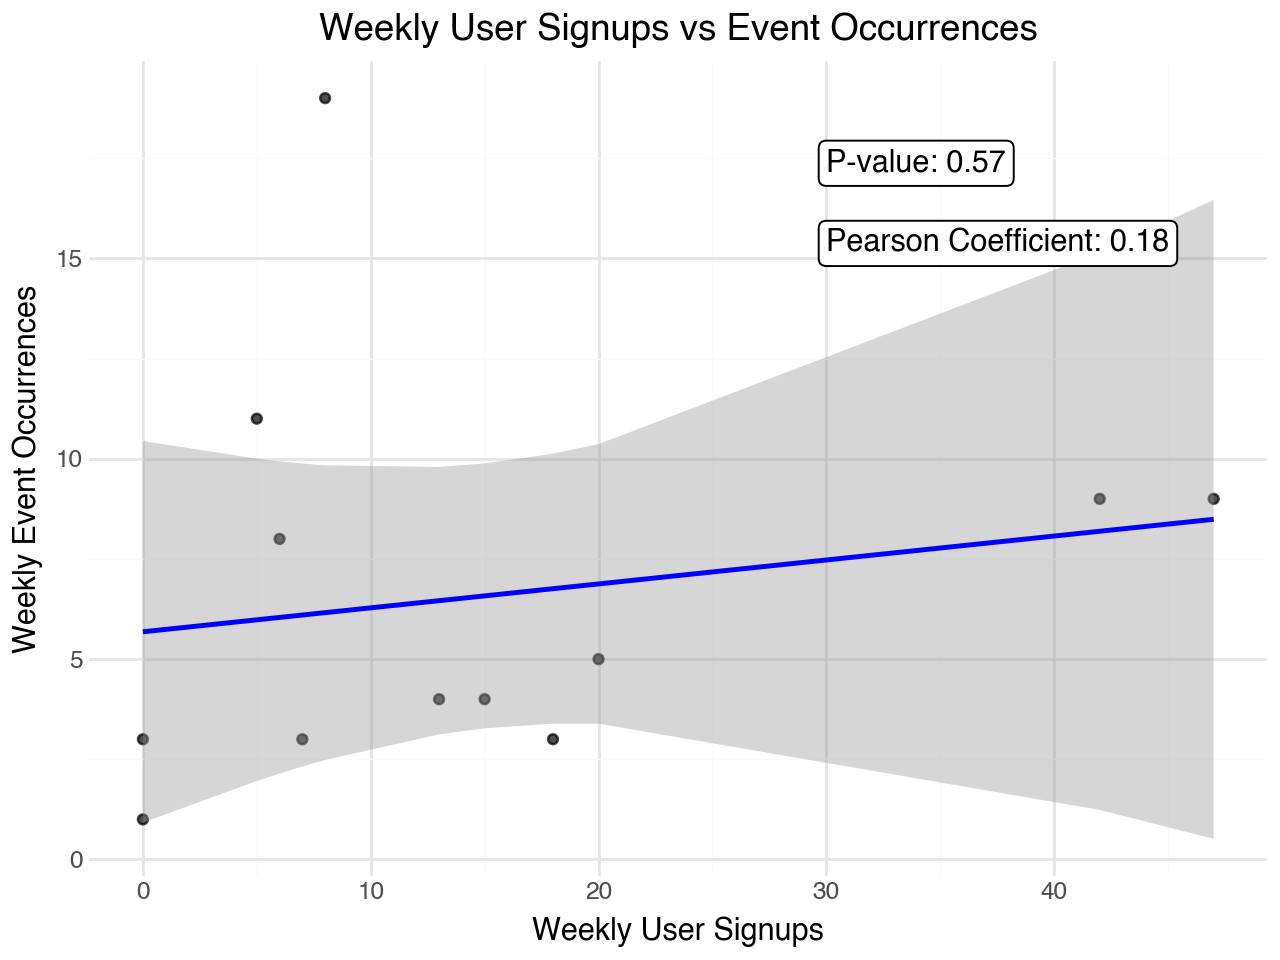

In [46]:
labels_df = pd.DataFrame({
    'x': [30, 30],
    'y': [15, 17],
    'label': [f'Pearson Coefficient: {correlation:.2f}', f'P-value: {p_value:.2f}']
})

correlation_scatter = (
    ggplot(merged_df2, aes('user_signups', 'event_dates')) +
    geom_point(alpha=0.7) +
    labs(title='Weekly User Signups vs Event Occurrences',
         x='Weekly User Signups',
         y='Weekly Event Occurrences') +
    theme_minimal() +
    geom_smooth(method='lm', color='blue') +
    geom_label(data=labels_df, mapping=aes(x='x', y='y', label='label'), ha='left', va='bottom')
)
correlation_scatter.show()